# Digital Signal and Image Processing Project - Image Retrieval

# Imports and Dataset

In [167]:
from google.colab import drive
import zipfile
import shutil
import os
import numpy as np
import random as python_random
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.neighbors import KDTree
from sklearn.metrics import accuracy_score, classification_report

from keras.layers import Input, Lambda
from keras.optimizers import Adam
from keras import backend as K
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Activation
from keras.models import Sequential, Model
from keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation
from keras.optimizers import SGD
from keras.utils import to_categorical
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing import image
from keras import applications
import numpy as np
import glob
from IPython.core.display import Image

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import layers, Model
from tensorflow.keras.metrics import Metric
from scipy.spatial.distance import cdist
from sklearn.metrics import confusion_matrix, classification_report
import random

np.random.seed(0)
python_random.seed(0)
tf.random.set_seed(0)
keras.utils.set_random_seed(0)
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Dataset Import and Split

The dataset is imported, extracted and divided into train-val-test sets, with a proportion of 60-20-20.

The folder "dataset" is created which contains 3 sub folders for the 3 splits. The images are still divided by category.

Dictionaries are used to map label indices to their corresponding category names and vice versa.

### For Pre-Trained approach

In [168]:
# Transfer dataset, and extract files
shutil.copy('/content/drive/My Drive/MammalsDataset.zip', 'MammalsDataset.zip')
zipf = zipfile.ZipFile('MammalsDataset.zip')
zipf.extractall()
zipf.close()

os.remove('MammalsDataset.zip') # Delete the copied zip file

In [169]:
dataset_origin_path = "mammals"
dataset_path = "dataset"
train_ratio, val_ratio, test_ratio = 0.6, 0.2, 0.2

# Create destination directories
for split in ['train', 'val', 'test']:
    split_path = os.path.join(dataset_path, split)
    os.makedirs(split_path, exist_ok=True)

# Iterate through each category (sub-folder)
for category in os.listdir(dataset_origin_path):
    category_path = os.path.join(dataset_origin_path, category)

    images = os.listdir(category_path)
    python_random.shuffle(images)

    train_end = int(train_ratio * len(images))
    val_end = train_end + int(val_ratio * len(images))

    splits = {
        'train': images[:train_end],
        'val': images[train_end:val_end],
        'test': images[val_end:]
    }

    # Move images to respective directories
    for split, split_images in splits.items():
        split_category_path = os.path.join(dataset_path, split, category)
        os.makedirs(split_category_path, exist_ok=True)

        for img in split_images:
            shutil.move(os.path.join(category_path, img), os.path.join(split_category_path, img))

    # Remove empty category folder
    os.rmdir(category_path)

# Remove the original dataset folder if empty
if not os.listdir(dataset_origin_path):
    os.rmdir(dataset_origin_path)

print("Dataset split completed successfully.")


Dataset split completed successfully.


Dictionaries are created in order to map label indices to their corresponding category names and vice versa, whenever this will be needed later in the project.

In [170]:
category_names = sorted([d for d in os.listdir(dataset_path + "/train") if os.path.isdir(os.path.join(dataset_path + "/train", d))])
category_to_index = {name: i for i, name in enumerate(category_names)}
index_to_category = {i: name for name, i in category_to_index.items()}

### For training siamese network aproach

In [171]:
# Transfer dataset, and extract files
shutil.copy('/content/drive/My Drive/mammals_reduced.zip', 'mammals_reduced.zip')

# Open the ZIP file using a 'with' statement to ensure proper handling
with zipfile.ZipFile('mammals_reduced.zip', 'r') as zipf:
    # Extract all files from the ZIP archive
    zipf.extractall()

os.remove('mammals_reduced.zip') # Delete the copied zip file

In [172]:
# Versione ridotta del dataset
dataset_origin_path_reduced = "mammals_reduced"
dataset_path_reduced = "dataset_reduced"

train_ratio, val_ratio, test_ratio = 0.6, 0.2, 0.2

# Crea le cartelle di destinazione per il dataset ridotto
for split in ['train', 'val', 'test']:
    split_path = os.path.join(dataset_path_reduced, split)
    os.makedirs(split_path, exist_ok=True)

# Itera su ogni categoria nel dataset ridotto
for category in os.listdir(dataset_origin_path_reduced):
    category_path = os.path.join(dataset_origin_path_reduced, category)

    # Controlla che sia una cartella (evita file strani)
    if not os.path.isdir(category_path):
        continue

    images = os.listdir(category_path)
    python_random.shuffle(images)

    train_end = int(train_ratio * len(images))
    val_end = train_end + int(val_ratio * len(images))

    splits = {
        'train': images[:train_end],
        'val': images[train_end:val_end],
        'test': images[val_end:]
    }

    # Sposta le immagini nelle rispettive directory
    for split, split_images in splits.items():
        split_category_path = os.path.join(dataset_path_reduced, split, category)
        os.makedirs(split_category_path, exist_ok=True)

        for img in split_images:
            shutil.move(os.path.join(category_path, img), os.path.join(split_category_path, img))

    # Rimuovi la cartella vuota
    os.rmdir(category_path)

print("Dataset split completed successfully.")


Dataset split completed successfully.


Dictionaries are created in order to map label indices to their corresponding category names and vice versa, whenever this will be needed later in the project.

In [173]:
category_names_reduced = sorted([d for d in os.listdir(dataset_path_reduced + "/train") if os.path.isdir(os.path.join(dataset_path_reduced + "/train", d))])
category_to_index_reduced = {name: i for i, name in enumerate(category_names_reduced)}
index_to_category_reduced = {i: name for name, i in category_to_index_reduced.items()}

# Pre-Trained CNN Approach
This section explores the base approach of extracting the feature arrays from a pre-trained network (MobileNetV2), and using a kd-tree to retrieve similar images quickly.

## Functions

In [174]:
def extract_features(model, root_folder, category_to_index, preprocess_function, image_size=(224, 224)):
    """
    Extract features from images in a root folder organized into subfolders by labels.
    Returns the features, the labels, and the corresponding image paths.
    """
    features = []
    labels = []
    image_paths = []

    for category in sorted(os.listdir(root_folder)):
        category_path = os.path.join(root_folder, category)
        print("Processing folder", category_path)

        if os.path.isdir(category_path):
            if category not in category_to_index:
                print(f"Skipping folder '{category}' as it is not in the category mapping.")
                continue

            label = category_to_index[category]  # Convert category name to label index

            image_files = [fname for fname in os.listdir(category_path) if fname.lower().endswith(('jpg', 'jpeg', 'png'))]

            for fname in image_files:
                image_path = os.path.join(category_path, fname)

                image = load_img(image_path, target_size=image_size)
                image_array = img_to_array(image)
                image_array = preprocess_function(image_array)
                image_array = np.expand_dims(image_array, axis=0)

                feature = model.predict(image_array, verbose=0)

                features.append(feature.flatten())
                labels.append(label)
                image_paths.append(image_path)

    return np.array(features), np.array(labels), image_paths

In [175]:
def load_or_compute_features(model, features_path, labels_path, paths_path, images_folder, category_to_index, preprocess_function=preprocess_input):
    """
    This function loads the saved features, labels and image paths (if available),
    otherwise it computes, saves them and returns them.
    """
    # Check if the feature, label, and image path files exist
    if os.path.exists(features_path):
        # Load the files if they exist
        train_features = np.load(features_path)
        train_labels = np.load(labels_path)
        train_image_paths = list(np.load(paths_path, allow_pickle=True))
        print("Loaded existing files.")
    else:
        # Otherwise, compute them
        print("Files missing, computing features...")
        train_features, train_labels, train_image_paths = extract_features(model, images_folder, category_to_index, preprocess_function)

        # Create the folder if it doesn't exist already
        features_save_folder = os.path.dirname(features_path)
        if not os.path.exists(features_save_folder):
            os.makedirs(features_save_folder)

        # Save the computed features, labels, and image paths
        np.save(features_path, train_features)
        np.save(labels_path, train_labels)
        np.save(paths_path, train_image_paths)
        print("Computed and saved new features.")

    return train_features, train_labels, train_image_paths

## Feature Extraction

Extraction of the features for every image in the train, val and test set. The numpy arrays are saved to disk to avoid re-computing them in later executions.

In [176]:
# Load of MobileNetV2 without the top layer
mobilenet = MobileNetV2(weights="imagenet", include_top=False, pooling="avg", input_shape=(224, 224, 3))

In [177]:
dataset_train_path = dataset_path + "/train"
prefix = "/content/drive/My Drive/" #""
train_features_path = prefix + "IR Saves/Pre-Trained Approach/train_features.npy"
train_labels_path = prefix + "IR Saves/Pre-Trained Approach/train_labels.npy"
train_image_names_path = prefix + "IR Saves/Pre-Trained Approach/train_image_names.npy"

train_features, train_labels, train_image_paths = load_or_compute_features(mobilenet, train_features_path, train_labels_path, train_image_names_path, dataset_train_path, category_to_index)

Loaded existing files.


In [178]:
dataset_val_path = dataset_path + "/val"
val_features_path = prefix + "IR Saves/Pre-Trained Approach/val_features.npy"
val_labels_path = prefix + "IR Saves/Pre-Trained Approach/val_labels.npy"
val_image_names_path = prefix + "IR Saves/Pre-Trained Approach/val_image_names.npy"

val_features, val_labels, val_image_paths = load_or_compute_features(mobilenet, val_features_path, val_labels_path, val_image_names_path, dataset_val_path, category_to_index)

Loaded existing files.


In [179]:
dataset_test_path = dataset_path + "/test"
test_features_path = prefix + "IR Saves/Pre-Trained Approach/test_features.npy"
test_labels_path = prefix + "IR Saves/Pre-Trained Approach/test_labels.npy"
test_image_names_path = prefix + "IR Saves/Pre-Trained Approach/test_image_names.npy"

test_features, test_labels, test_image_paths = load_or_compute_features(mobilenet, test_features_path, test_labels_path, test_image_names_path, dataset_test_path, category_to_index)

Loaded existing files.


This means that the train features are 1280 long arrays, for each of the 8234 images.

In [180]:
train_features.shape

(8234, 1280)

## Image Retrieval
This section creates the kd-tree, evaluates it and explores the results.

### Functions

In [181]:
def print_retrieved_images(train_image_paths, test_image_paths, test_image_indices, query_indexes, query_distances):
    """
    Plots the query image and its k nearest neighbors for each test image.
    """
    # Number of test images to plot
    num_test_images = len(test_image_indices)

    # Number of nearest neighbors to display
    k = len(query_indexes[0])

    # Adjust the figsize dynamically based on the number of images to display horizontally
    fig_width = 3 * (k + 1)  # 1 for the query image and k for neighbors
    fig_height = 3 * num_test_images  # 3 units of height per image row

    # Set up the plot with multiple rows (one for each test image) and (k + 1) columns (1 for the query image and k for neighbors)
    fig, axes = plt.subplots(num_test_images, k + 1, figsize=(fig_width, fig_height))

    # Loop over each test image index
    for i, test_image_index in enumerate(test_image_indices):
        # Get the test image
        test_image_path = test_image_paths[test_image_index]
        test_image = load_img(test_image_path)

        # Extract category (folder name) and image name for the test image
        test_image_category = os.path.basename(os.path.dirname(test_image_path))
        test_image_name = os.path.basename(test_image_path)

        # Plot the test image (query)
        axes[i, 0].imshow(test_image)
        axes[i, 0].set_title(f"Query:\n {test_image_name}")
        axes[i, 0].axis('off')  # Hide axes for the image

        # Plot the k nearest images
        for j, (index, dist) in enumerate(zip(query_indexes[i], query_distances[i])):
            # Load the neighbor image
            neighbor_image_path = train_image_paths[index]
            neighbor_image = load_img(neighbor_image_path)

            # Extract the category (folder name) and name for the neighbor image
            neighbor_category = os.path.basename(os.path.dirname(neighbor_image_path))
            neighbor_name = os.path.basename(neighbor_image_path)

            # Plot the neighbor image
            axes[i, j + 1].imshow(neighbor_image)
            axes[i, j + 1].set_title(f"{neighbor_name}\n(Dist: {dist:.2f})")
            axes[i, j + 1].axis('off')  # Hide axes for the image

    plt.tight_layout()
    plt.show()


In [182]:
def evaluate_performance(query_indexes, test_labels, train_labels, index_to_category, k=3):
    """
    Evaluate the performance of the using the provided indices.
    For each test image, check each of the k nearest neighbors individually.
    """
    # List to store predictions and true labels for classification report
    predicted_labels = []
    true_labels = []

    # Loop over each test image
    for i, query_index in enumerate(query_indexes):
        # Get the true label for the test image
        true_label = test_labels[i]

        # Get the labels of the k nearest neighbors
        neighbor_labels = train_labels[query_index]

        # Check each neighbor individually and append to predictions
        for neighbor_label in neighbor_labels:
            predicted_labels.append(neighbor_label)  # Store the predicted neighbor label
            true_labels.append(true_label)           # Store the true label for the test sample

    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predicted_labels)
    print(f"Accuracy: {accuracy * 100:.2f}%")

    # Generate the classification report
    print("\nClassification Report:")

    # Convert numeric labels to category names using index_to_category
    category_names = [index_to_category[label] for label in np.unique(train_labels)]

    # Print the classification report with category names
    print(classification_report(true_labels, predicted_labels, target_names=category_names))

    # Generate classification report as a dictionary for easier extraction of metrics
    report = classification_report(true_labels, predicted_labels, target_names=category_names, output_dict=True)

    # Extract precision, recall, and f1-score for each class
    class_report = []
    for class_name, metrics in report.items():
        if class_name not in ['accuracy', 'macro avg', 'weighted avg']:  # Ignore overall averages
            class_report.append({
                'Class': class_name,
                'Precision': metrics['precision'],
                'Recall': metrics['recall'],
                'F1-Score': metrics['f1-score']
            })

    # Convert the class report to a DataFrame
    report_df = pd.DataFrame(class_report)

    return report_df


In [183]:
def calculate_anmrr(query_indexes, test_labels, train_labels, k=3):
    """
    Calculate Average Normalized Modified Retrieval Rank (ANMRR)s.
    """
    tests_number = len(query_indexes)  # Number of queries
    total_score = 0

    for i, query_index in enumerate(query_indexes):
        true_label = test_labels[i]  # True label of the current query

        # Get the labels of the k nearest neighbors
        neighbor_labels = train_labels[query_index]

        # Compute AVR(q) - the average rank of relevant documents
        relevant_ranks = []
        for rank, neighbor_label in enumerate(neighbor_labels):
            if neighbor_label == true_label:
                relevant_ranks.append(rank + 1)  # Add 1 to convert from 0-indexed to 1-indexed rank

        if relevant_ranks:
            average_rank_relevant_documents = np.mean(relevant_ranks)  # Average rank of relevant documents
        else:
            average_rank_relevant_documents = k + 1  # If no relevant documents found, set to K + 1

        # Calculate the ANMRR for the query
        number_relevant_documents = 1
        denominator = 1.25 * k - 0.5 * (1 + number_relevant_documents)
        if denominator == 0:  # Handle case when the denominator becomes zero
            continue  # Skip this query, as division by zero is not valid

        score = (average_rank_relevant_documents - 0.5 * (1 + number_relevant_documents)) / denominator
        total_score += score

    # Return the final ANMRR score
    ANMRR = total_score / tests_number
    return ANMRR

In [184]:
def retrieve_and_evaluate_category(kd_tree, category_name, num_images, root_test_folder, category_to_index):
    """
    Retrieves and evaluates images for a specific category using a KD-Tree.
    """

    print(f"Retrieving images for category {category_name}...")

    # Get the category index from the category name using the category_to_index mapping
    if category_name not in category_to_index:
        raise ValueError(f"Category '{category_name}' not found in the category_to_index mapping.")

    category_index = category_to_index[category_name]

    # Find indices of test images belonging to the specified category
    test_image_indices = [i for i, label in enumerate(test_labels) if label == category_index]

    # Limit the number of images to num_images (if available)
    test_image_indices = test_image_indices[:min(num_images, len(test_image_indices))]

    # Extract features for the selected test images
    test_images = test_features[test_image_indices]

    # Perform k-NN search using the KD-Tree
    k = 3  # Number of neighbors to retrieve
    query_distances, query_indexes = kd_tree.query(test_images, k=k)

    # Print retrieved images
    print_retrieved_images(train_image_paths, test_image_paths, test_image_indices, query_indexes, query_distances)

    # Calculate and print ANMRR
    anmrr_value = calculate_anmrr(query_indexes, test_labels[test_image_indices], train_labels, k=k)
    print(f"ANMRR for category {category_name}: {anmrr_value:.4f}")

### KD-Tree

The kd-tree is created on the train fetures that were extracted earlier.

In [185]:
kd_tree = KDTree(train_features)

#### Testing on a few images

Testing the kd-tree and its returned data on 3 random images.

In [186]:
len(test_features)

2786

The images are picked with 3 random indices, and their respective feature arrays are retrieved.

In [187]:
test_image_indices = [0, 1000, 2000]
test_images = test_features[test_image_indices]
test_images.shape

(3, 1280)

5 images are retrieved for each one of the 3 test images.

In [188]:
distances, indices = kd_tree.query(test_images, k=5)

In [189]:
distances

array([[10.6440622 , 11.27122175, 11.38418707, 11.45711442, 11.55489566],
       [13.98400394, 14.20867247, 14.53729454, 14.88539909, 15.72077313],
       [10.92176433, 11.22464048, 11.43872234, 11.67204099, 11.83940762]])

In [190]:
indices

array([[  54,   58,   87,  108,   33],
       [2928, 2904, 2834, 2803, 2840],
       [5968, 5988, 5865, 5985, 5940]])

This function takes the result of the kd-tree query and displays dynamically the original image and all of the retrieved images, with useful informations displayed in the titles.

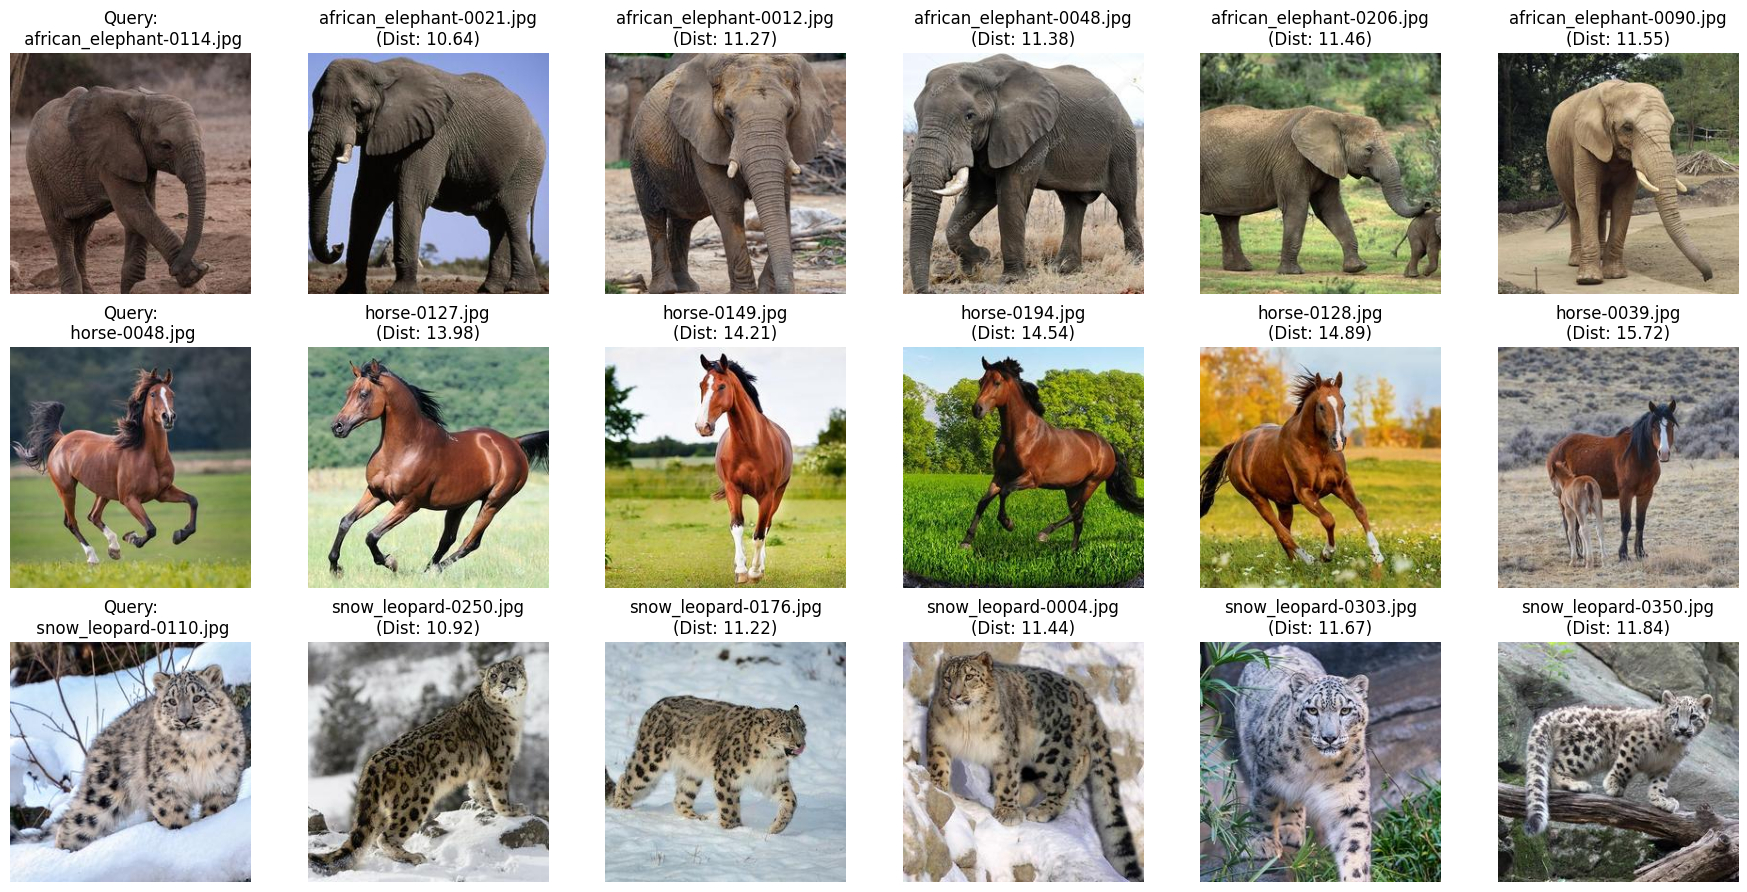

In [191]:
print_retrieved_images(train_image_paths, test_image_paths, test_image_indices, indices, distances)

#### Evaluation
The method is then more thoroughly evaluated by retrieving 3 images for each test image.

In [192]:
k = 3
query_distances, query_indexes = kd_tree.query(test_features, k=k)

This function takes the result of the kd-tree query, calculates and displays the accuracy and the classification report.

In [193]:
performance_df = evaluate_performance(query_indexes, test_labels, train_labels, index_to_category, k)

Accuracy: 86.97%

Classification Report:
                  precision    recall  f1-score   support

african_elephant       0.95      0.98      0.96       210
          alpaca       0.86      0.85      0.86       204
  american_bison       0.88      0.95      0.91       210
        anteater       0.85      0.78      0.81       183
      arctic_fox       0.91      0.93      0.92       189
       armadillo       0.96      0.96      0.96       201
          baboon       0.92      0.92      0.92       198
          badger       0.82      0.88      0.85       186
      blue_whale       0.73      0.66      0.69       150
      brown_bear       0.90      0.92      0.91       180
           camel       0.89      0.90      0.89       156
         dolphin       0.79      0.84      0.81       189
         giraffe       0.95      0.98      0.97       183
       groundhog       0.84      0.97      0.90       189
 highland_cattle       0.87      0.86      0.86       189
           horse       0.93   

Since the classification report isn't much readable due to the large number of classes, the function also returns a dataframe which can be easily navigated.

In [194]:
performance_df.sort_values(by='F1-Score', ascending=False)[:10]

Class  Precision    Recall  F1-Score
31      snow_leopard   0.995192  0.985714  0.990431
23         orangutan   0.962264  1.000000  0.980769
18             koala   0.969849  0.989744  0.979695
44             zebra   0.958824  0.987879  0.973134
27         red_panda   0.974874  0.965174  0.970000
12           giraffe   0.952381  0.983607  0.967742
0   african_elephant   0.949074  0.976190  0.962441
26         porcupine   0.954545  0.969231  0.961832
5          armadillo   0.960000  0.955224  0.957606
6             baboon   0.915000  0.924242  0.919598

Analyzing the classes which are harded to retrieve correctly will give us insights on what this method is struggling with.

In [195]:
performance_df.sort_values(by='F1-Score', ascending=True)[:10]

Class  Precision    Recall  F1-Score
30           seal   0.631250  0.510101  0.564246
29       sea_lion   0.655660  0.681373  0.668269
8      blue_whale   0.727941  0.660000  0.692308
43            yak   0.711409  0.679487  0.695082
37         walrus   0.763636  0.724138  0.743363
39  water_buffalo   0.812155  0.765625  0.788204
36         vicuna   0.838983  0.767442  0.801619
41     wildebeest   0.810811  0.806452  0.808625
35    vampire_bat   0.937500  0.714286  0.810811
11        dolphin   0.793970  0.835979  0.814433

The ANMRR (Average Normalized Modified Retrieval Rank) score is a measure of retrieval effectiveness. It ranges between 0 and 1 where 0 indicates perfect retrieval, meaning that all relevant items are ranked at the top, and 1 indicates worst-case retrieval, meaning relevant items are ranked very poorly or not retrieved at all. The "rank" is the position of the correctly retrieved images in the returned array, where the top of the ranking is occupied by the image with lowest distance to the query image.

A ANMRR score of 0.3914 is not bad.

In [196]:
anmrr_value = calculate_anmrr(query_indexes, test_labels, train_labels, k=3)
print(f"ANMRR: {anmrr_value:.4f}")

ANMRR: 0.3914


This function is used to explore a single category by testing on a given number of images, displaying the results and calculating the class-specific ANMRR score.

The issue with this class is clearly due to the high similarity with other categories like "highland_cattle" and "american_bison".

Some of these images could also be mistakes of the dataset itself, but since we are not experts of wild life, it's hard to tell.

Retrieving images for category yak...


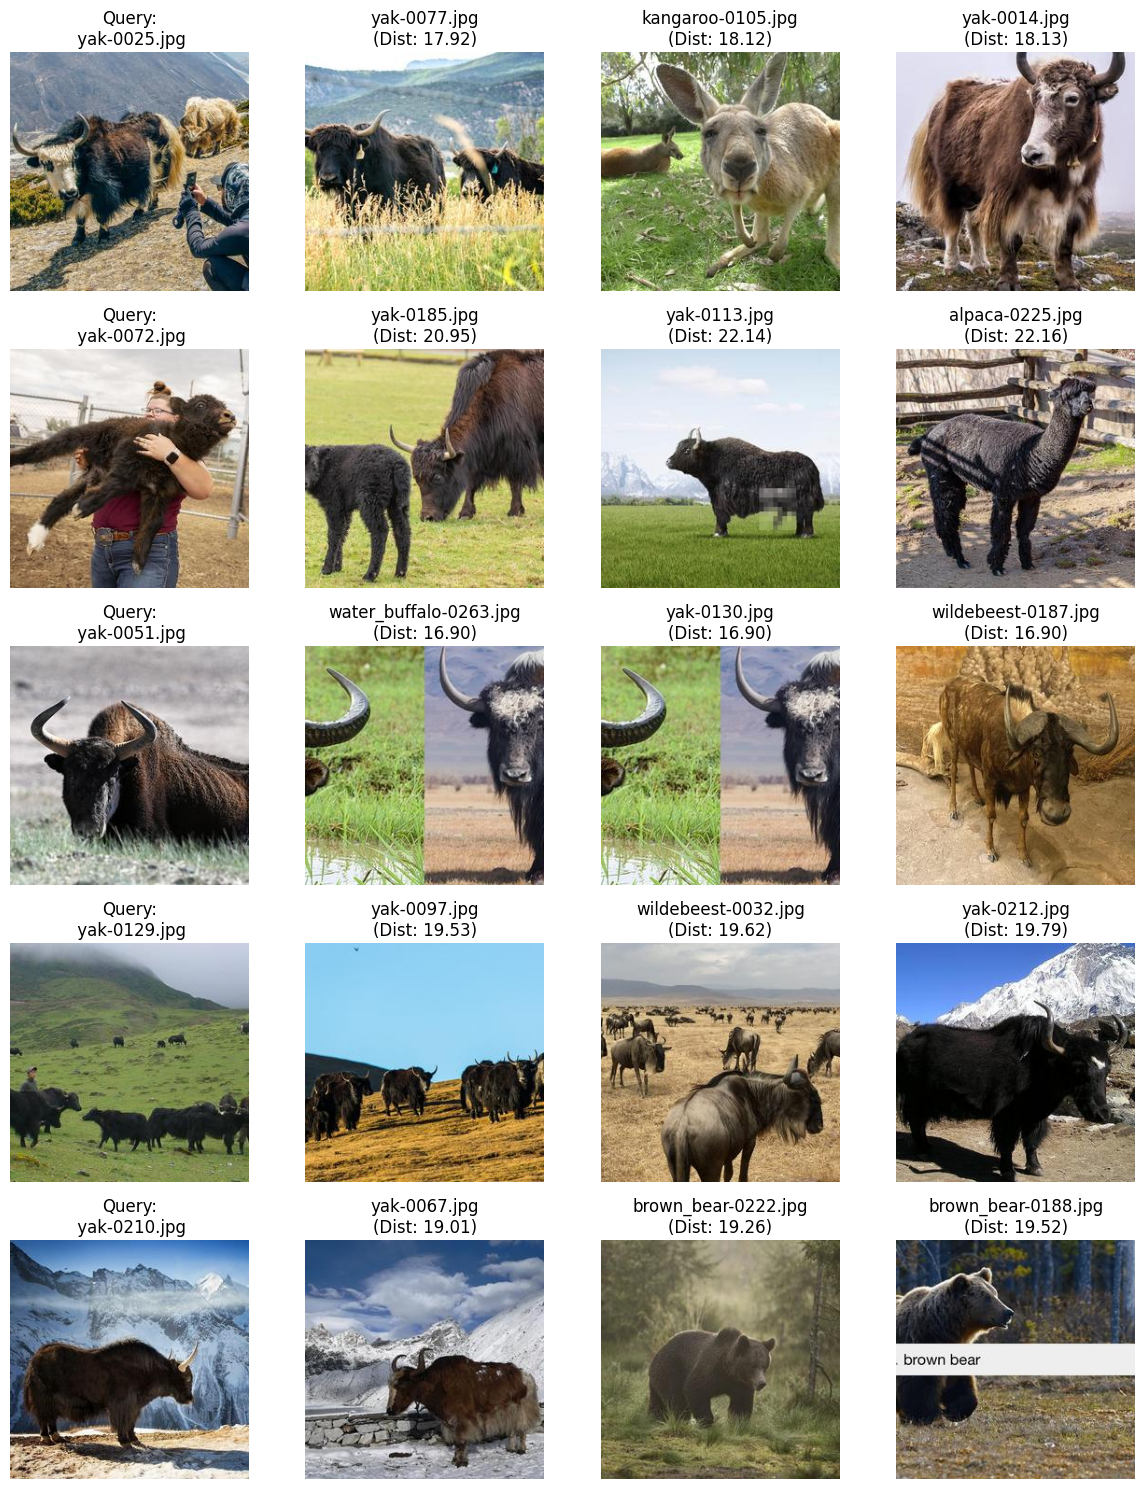

ANMRR for category yak: 0.2545


In [197]:
retrieve_and_evaluate_category(kd_tree, "yak", 5, dataset_test_path, category_to_index)

# Siamese Network Approach

In order to make a siamese network with triplet loss we'll need the following pieces:
- Encoder model: A single neural network used to transform each image into a feature vector (embedding).
- Triples loss function that evaluates loss on:
  - Anchor (the reference image)
  - Positive (an image of the same class as the Anchor)
  - Negative (an image from a different class)

## Setup functions

### Triplet Loss function

The triplet loss forces (Anchor - Positive) to come closer and (Anchor - Negative) to move away.

In [198]:
def triplet_loss(margin=0.1):
    def loss(y_true, y_pred):
        anchor, positive, negative = y_pred[:, 0, :], y_pred[:, 1, :], y_pred[:, 2, :]
        pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=1)
        neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=1)
        loss = tf.maximum(pos_dist - neg_dist + margin, 0.0)
        return tf.reduce_mean(loss)

    return loss

### Encoder network

This is pretty much the center of the whole siamese architecture, it will take in input 3 images and evaluate loss using custom loss fuction previosly designed

In [199]:
def build_custom_encoder():
    """
    Costruisce un encoder CNN da zero per l'estrazione di feature.
    """
    inputs = layers.Input(shape=(224, 224, 3))

    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(inputs)
    x = layers.BatchNormalization()(x, training=True)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
    #x = layers.BatchNormalization()(x, training=True)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(x)
    #x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation="relu")(x)  # Embedding di 128 dimensioni
    x = layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1), output_shape=(128,))(x) # Normalizzazione L2

    return Model(inputs, x, name="custom_encoder")


### Triplet generator

We need to create a function to sample (Anchor, Positive, Negative). This will later be used by our encoder function to process 3 images at a time. We can do this by loading the dataset and selecting the images by class.

In [200]:
IMG_SIZE = (224, 224)
batch_size = 64

In [201]:
# Load image
def load_image(img_path):
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels=3)  # Ensure 3 channels
    image = tf.image.resize(image, IMG_SIZE)  # Ensure correct size
    image = image / 255.0  # Normalize
    return image

In [202]:
def load_triplet(dictionary, dataset_path, split='train'):
    """
    Load one sample, wich will be composed of a (Anchor, Positive, Negative) images combination
    """
    class_names = list(dictionary.keys())

    # chose a random class
    pos_class = np.random.choice(class_names)
    pos_class_path = os.path.join(dataset_path, split, pos_class)

    # choose 2 images from same class
    pos_images = os.listdir(pos_class_path)
    if len(pos_images) < 2:
            # Recursion for classes with <2 images
            return load_triplet(dictionary, dataset_path, split)

    anchor_img, positive_img = np.random.choice(pos_images, 2, replace=False)

    # choose a different random class
    neg_class = np.random.choice([c for c in class_names if c != pos_class])
    neg_class_path = os.path.join(dataset_path, split, neg_class)
    negative_img = np.random.choice(os.listdir(neg_class_path))

    anchor = load_image(os.path.join(pos_class_path, anchor_img))
    positive = load_image(os.path.join(pos_class_path, positive_img))
    negative = load_image(os.path.join(neg_class_path, negative_img))

    return anchor, positive, negative, dictionary[pos_class]

Next we need a custom data generator to give the model 3 images to process at once, this function will be called inside data generator to laoad each triplet:

In [203]:
def triplet_generator(dictionary, batch_size, dataset_path, split):
    while True:
        anchors, positives, negatives, labels = [], [], [], []

        for _ in range(batch_size):
            anchor, positive, negative,label = load_triplet(dictionary, dataset_path, split)  # Carica le immagini

            anchors.append(anchor)
            positives.append(positive)
            negatives.append(negative)
            labels.append(label)

        # Convertiamo in tensori e restituiamo separatamente
        yield (np.array(anchors), np.array(positives), np.array(negatives)), np.array(labels)

This is a simple function that will keep gettting one sample afeter the other when it's called. thus inizializating it is pretty simple but will cause some overhead while running the training

### Prepare custom dataset

This is custom the previously mentioned data generator definition:

In [204]:
def create_triplet_dataset(dictionary, batch_size, dataset_path, split):
    def gen():
        while True:
            yield next(triplet_generator(dictionary, batch_size, dataset_path, split))

    output_signature = (
        (tf.TensorSpec(shape=(batch_size, 224, 224, 3), dtype=tf.float32),  # Anchor
         tf.TensorSpec(shape=(batch_size, 224, 224, 3), dtype=tf.float32),  # Positive
         tf.TensorSpec(shape=(batch_size, 224, 224, 3), dtype=tf.float32)),  # Negative
        tf.TensorSpec(shape=(batch_size,), dtype=tf.float32)  # Dummy label
    )

    return tf.data.Dataset.from_generator(gen, output_signature=output_signature)

Next we create dataset using previous generator function and we test evrything so far is coded correctly by printing some shapes and images

Anchor shape: (64, 224, 224, 3)
Positive shape: (64, 224, 224, 3)
Negative shape: (64, 224, 224, 3)
Labels shape: (64,)
labels tf.Tensor(11.0, shape=(), dtype=float32)


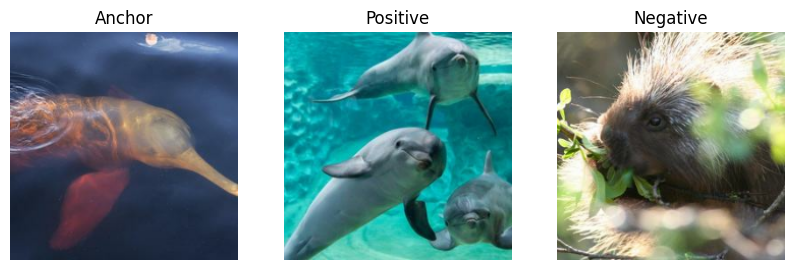

In [205]:
train_dataset_reduced = create_triplet_dataset(dictionary=category_to_index, batch_size=batch_size, dataset_path=dataset_path, split="train")

validation_dataset_reduced = create_triplet_dataset(dictionary=category_to_index, batch_size=batch_size, dataset_path=dataset_path, split="val")

for batch in train_dataset_reduced.take(1):
    (anchors, positives, negatives), labels = batch

    print("Anchor shape:", anchors.shape)
    print("Positive shape:", positives.shape)
    print("Negative shape:", negatives.shape)
    print("Labels shape:", labels.shape)


# Fetch one batch and display a sample
for batch in train_dataset_reduced.take(1):
    (anchors, positives, negatives), labels = batch
    print("labels", labels[0])
    fig, axes = plt.subplots(1, 3, figsize=(10, 5))
    axes[0].imshow((anchors[0].numpy() * 255).astype("uint8"))
    axes[0].set_title("Anchor")
    axes[1].imshow((positives[0].numpy() * 255).astype("uint8"))
    axes[1].set_title("Positive")
    axes[2].imshow((negatives[0].numpy() * 255).astype("uint8"))
    axes[2].set_title("Negative")
    for ax in axes:
        ax.axis("off")
    plt.show()
    break


Evrything should be working correctly as the graph showing triplet seems correct and each shape is the right dimension

### Siamese network definition

The following network is nothing more that a mere wrapping of encoder netork, it is useful to evaluate custom triplet-loss function and taking 3 inputs at a time:

In [206]:
def build_siamese_model(encoder):
    """
    Costruisce il modello Siamese che prende in input triplette.
    """
    anchor_input = layers.Input(shape=(224, 224, 3), name="anchor")
    positive_input = layers.Input(shape=(224, 224, 3), name="positive")
    negative_input = layers.Input(shape=(224, 224, 3), name="negative")

    anchor_emb = encoder(anchor_input)
    positive_emb = encoder(positive_input)
    negative_emb = encoder(negative_input)

    embeddings = layers.Lambda(lambda x: tf.stack(x, axis=1), output_shape=(3, 128))([anchor_emb, positive_emb, negative_emb])

    return Model(inputs=[anchor_input, positive_input, negative_input], outputs=embeddings, name="siamese_network")


## Train network

Defining encoder:

In [207]:
# Build new encoder model
encoder = build_custom_encoder()
encoder.summary()

Model: "custom_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 224, 224, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_10          │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_8 (Lambda)                    │ (None, 128)                 │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 403,968 (1.54 MB)

 Trainable params: 403,840 (1.54 MB)

 Non-trainable params: 128 (512.00 B)

Defining wrapper

In [208]:
# Creiamo la rete Siamese con il nuovo encoder
siamese_model = build_siamese_model(encoder)
siamese_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss=[triplet_loss(),"categorical_crossentropy"]
)

siamese_model.summary()

Model: "siamese_network"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ anchor (InputLayer)       │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ positive (InputLayer)     │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ negative (InputLayer)     │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ custom_encoder            │ (None, 128)            │        403,968 │ anchor[0][0],          │
│ (Functional)              │                        │                │ positive[0][0],        │
│                           │                        │                │ negative[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_9 (Lambda)         │ (None, 3, 128)         │              0 │ custom_encoder[0][0],  │
│                           │                        │                │ custom_encoder[1][0],  │
│                           │                        │                │ custom_encoder[2][0]   │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 403,968 (1.54 MB)

 Trainable params: 403,840 (1.54 MB)

 Non-trainable params: 128 (512.00 B)

Models not found. Building and training...
Epoch 1/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 51s 4s/step - lambda_9_loss: 0.0000e+00 - loss: 0.0897 - val_lambda_9_loss: 0.0000e+00 - val_loss: 0.0900
Epoch 2/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - lambda_9_loss: 0.0000e+00 - loss: 0.0814 - val_lambda_9_loss: 0.0000e+00 - val_loss: 0.0850
Epoch 3/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 37s 4s/step - lambda_9_loss: 0.0000e+00 - loss: 0.0766 - val_lambda_9_loss: 0.0000e+00 - val_loss: 0.0900
Epoch 4/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - lambda_9_loss: 0.0000e+00 - loss: 0.0783 - val_lambda_9_loss: 0.0000e+00 - val_loss: 0.0878
Epoch 5/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - lambda_9_loss: 0.0000e+00 - loss: 0.0755 - val_lambda_9_loss: 0.0000e+00 - val_loss: 0.0880
Epoch 6/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - lambda_9_loss: 0.0000e+00 - loss: 0.0872 - val_lambda_9_loss: 0.0000e+00 - val_loss: 0.0839
Epoch 7/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - lambda_9_loss: 0.0000e+00 - loss: 0.0795 

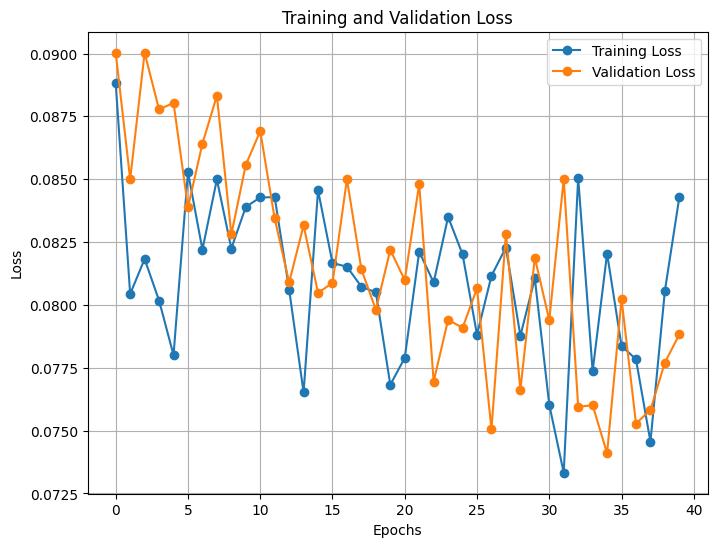

Models saved successfully to Google Drive.


In [209]:
# Define the load/save path (the folder)
model_folder = "/content/drive/My Drive/IR Saves/SiameseNetwork Approach"

# Create the folder if it doesn't exist
os.makedirs(model_folder, exist_ok=True)

# Define the full file paths
siamese_model_file = os.path.join(model_folder, "siamese_model.h5")
encoder_model_file = os.path.join(model_folder, "encoder_model.h5")

# Check if model files exist
if os.path.exists(siamese_model_file) and os.path.exists(encoder_model_file):
    # Load the models
    siamese_model = keras.models.load_model(siamese_model_file, custom_objects={'loss': triplet_loss()})
    encoder = keras.models.load_model(encoder_model_file)
    print("Models loaded successfully from Google Drive.")
else:
    # Build and train the models
    print("Models not found. Building and training...")

    history = siamese_model.fit(train_dataset_reduced,
                  epochs=40,
                  steps_per_epoch=10,
                  validation_steps = 10,
                  validation_data=validation_dataset_reduced
                  )

    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Create the directory if it doesn't exist
    os.makedirs(model_folder, exist_ok=True)

    # Save the models
    siamese_model.save(os.path.join(model_folder, "siamese_model.h5"))
    encoder.save(os.path.join(model_folder, "encoder_model.h5"))
    print("Models saved successfully to Google Drive.")


## Results analisis

In [210]:
prefix = "/content/drive/My Drive/" #

In [211]:
dataset_train_path = dataset_path + "/train"
train_features_path = prefix+"IR Saves/SiameseNetwork Approach/train_features.npy"
train_labels_path = prefix+"IR Saves/SiameseNetwork Approach/train_labels.npy"
train_image_names_path = prefix+"IR Saves/SiameseNetwork Approach/train_image_names.npy"

train_features_siamese , train_labels_siamese, train_image_paths_siamese = load_or_compute_features(encoder, train_features_path, train_labels_path, train_image_names_path, dataset_train_path, category_to_index)

Files missing, computing features...
Processing folder dataset/train/african_elephant
Processing folder dataset/train/alpaca
Processing folder dataset/train/american_bison
Processing folder dataset/train/anteater
Processing folder dataset/train/arctic_fox
Processing folder dataset/train/armadillo
Processing folder dataset/train/baboon
Processing folder dataset/train/badger
Processing folder dataset/train/blue_whale
Processing folder dataset/train/brown_bear
Processing folder dataset/train/camel
Processing folder dataset/train/dolphin
Processing folder dataset/train/giraffe
Processing folder dataset/train/groundhog
Processing folder dataset/train/highland_cattle
Processing folder dataset/train/horse
Processing folder dataset/train/jackal
Processing folder dataset/train/kangaroo
Processing folder dataset/train/koala
Processing folder dataset/train/manatee
Processing folder dataset/train/mongoose
Processing folder dataset/train/mountain_goat
Processing folder dataset/train/opossum
Process

In [212]:
dataset_val_path = dataset_path + "/val"
val_features_path = prefix+"IR Saves/SiameseNetwork Approach/val_features.npy"
val_labels_path = prefix+"IR Saves/SiameseNetwork Approach/val_labels.npy"
val_image_names_path = prefix+"IR Saves/SiameseNetwork Approach/val_image_names.npy"

val_features_siamese, val_labels_siamese, val_image_paths_siamese = load_or_compute_features(encoder, val_features_path, val_labels_path, val_image_names_path, dataset_val_path, category_to_index)

Files missing, computing features...
Processing folder dataset/val/african_elephant
Processing folder dataset/val/alpaca
Processing folder dataset/val/american_bison
Processing folder dataset/val/anteater
Processing folder dataset/val/arctic_fox
Processing folder dataset/val/armadillo
Processing folder dataset/val/baboon
Processing folder dataset/val/badger
Processing folder dataset/val/blue_whale
Processing folder dataset/val/brown_bear
Processing folder dataset/val/camel
Processing folder dataset/val/dolphin
Processing folder dataset/val/giraffe
Processing folder dataset/val/groundhog
Processing folder dataset/val/highland_cattle
Processing folder dataset/val/horse
Processing folder dataset/val/jackal
Processing folder dataset/val/kangaroo
Processing folder dataset/val/koala
Processing folder dataset/val/manatee
Processing folder dataset/val/mongoose
Processing folder dataset/val/mountain_goat
Processing folder dataset/val/opossum
Processing folder dataset/val/orangutan
Processing fo

In [213]:
dataset_test_path = dataset_path + "/test"
test_features_path = prefix+"IR Saves/SiameseNetwork Approach/test_features.npy"
test_labels_path = prefix+"IR Saves/SiameseNetwork Approach/test_labels.npy"
test_image_names_path = prefix+"IR Saves/SiameseNetwork Approach/test_image_names.npy"

test_features_siamese, test_labels_siamese, test_image_paths_siamese = load_or_compute_features(encoder, test_features_path, test_labels_path, test_image_names_path, dataset_test_path, category_to_index)

Files missing, computing features...
Processing folder dataset/test/african_elephant
Processing folder dataset/test/alpaca
Processing folder dataset/test/american_bison
Processing folder dataset/test/anteater
Processing folder dataset/test/arctic_fox
Processing folder dataset/test/armadillo
Processing folder dataset/test/baboon
Processing folder dataset/test/badger
Processing folder dataset/test/blue_whale
Processing folder dataset/test/brown_bear
Processing folder dataset/test/camel
Processing folder dataset/test/dolphin
Processing folder dataset/test/giraffe
Processing folder dataset/test/groundhog
Processing folder dataset/test/highland_cattle
Processing folder dataset/test/horse
Processing folder dataset/test/jackal
Processing folder dataset/test/kangaroo
Processing folder dataset/test/koala
Processing folder dataset/test/manatee
Processing folder dataset/test/mongoose
Processing folder dataset/test/mountain_goat
Processing folder dataset/test/opossum
Processing folder dataset/test

#### kd-tree

The kd-tree is created on the train fetures that were extracted earlier.

In [214]:
kd_tree = KDTree(train_features_siamese)

#### Testing on a few images

Testing the kd-tree and its returned data on 3 random images.

In [215]:
len(test_features_siamese)

2786

The images are picked with 3 random indices, and their respective feature arrays are retrieved.

In [216]:
test_image_indices_for_siamese = [0, 1000, 2000]
test_images_siamese = test_features_siamese[test_image_indices_for_siamese]
test_images_siamese.shape

(3, 128)

5 images are retrieved for each one of the 3 test images.

In [217]:
distances_siamese, indices_siamese = kd_tree.query(test_images_siamese, k=5)

In [218]:
distances_siamese

array([[0.01684277, 0.01708958, 0.02371927, 0.02586166, 0.02596861],
       [0.02772788, 0.03302907, 0.03523747, 0.03575524, 0.03989021],
       [0.02666255, 0.03987229, 0.04868482, 0.05035731, 0.05096465]])

In [219]:
indices_siamese

array([[6116, 4317, 4327, 2571, 1715],
       [5230,  162, 1379, 5200, 6170],
       [5927, 5928,    1, 4035, 6030]])

This function takes the result of the kd-tree query and displays dynamically the original image and all of the retrieved images, with useful informations displayed in the titles.

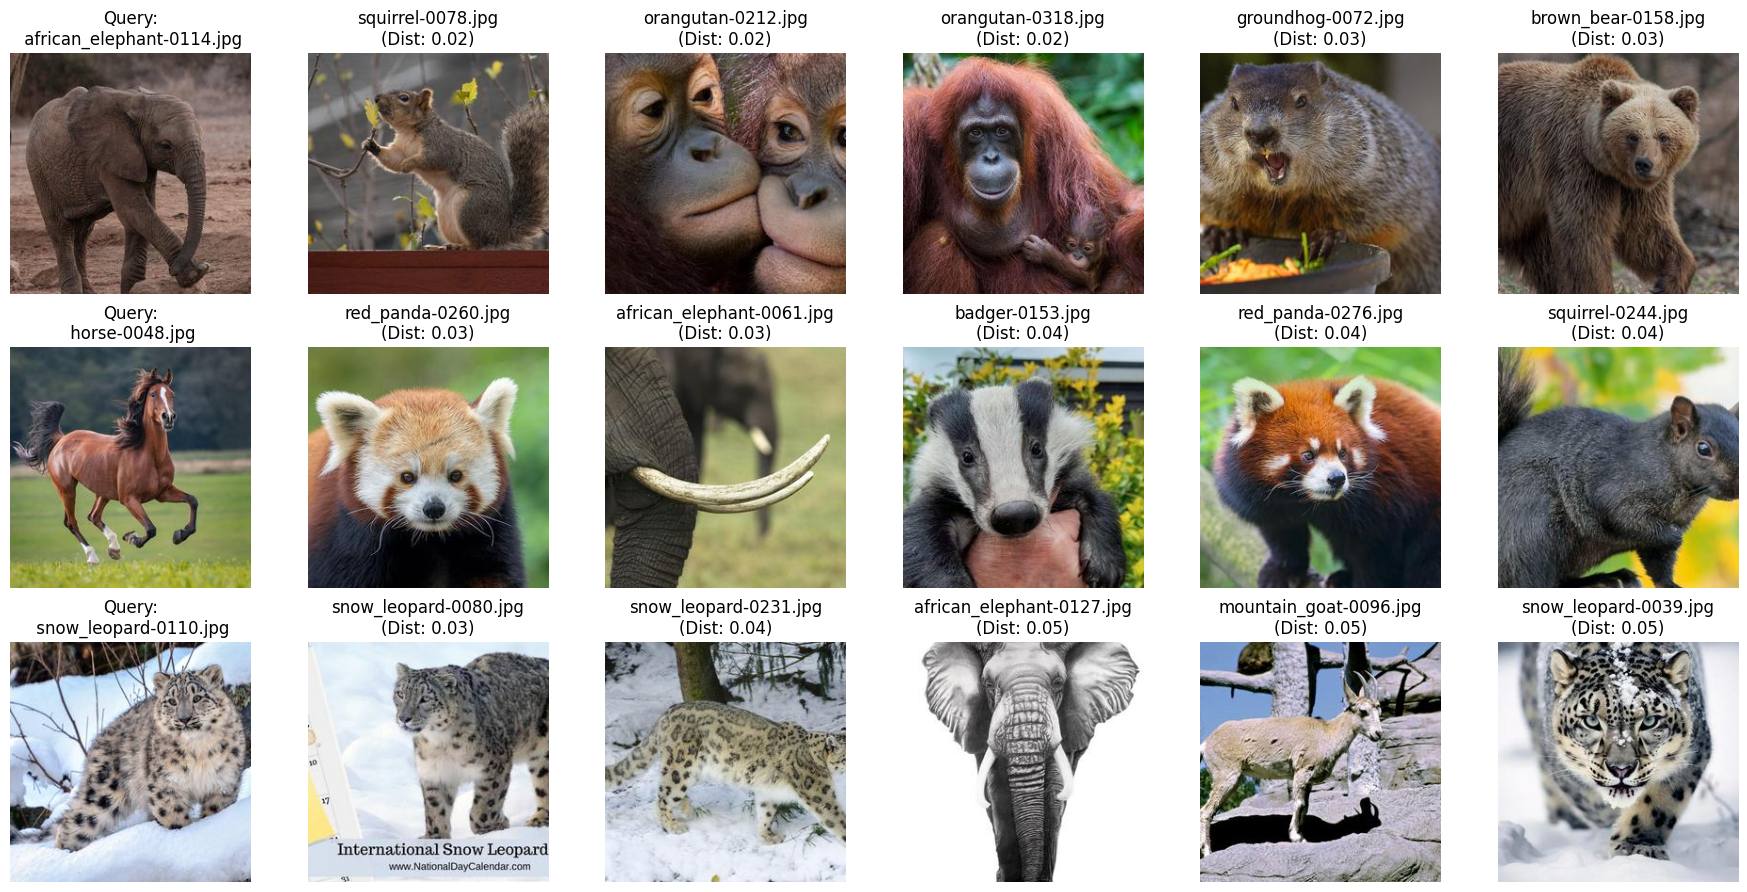

In [220]:
print_retrieved_images(train_image_paths_siamese, test_image_paths_siamese, test_image_indices_for_siamese, indices_siamese, distances_siamese)

#### Evaluation
The method is then more thoroughly evaluated by retrieving 3 images for each test image.

In [221]:
k = 3
query_distances_siamese, query_indexes_siamese = kd_tree.query(test_features_siamese, k=k)

This function takes the result of the kd-tree query, calculates and displays the accuracy and the classification report.

In [222]:
performance_df_siamese = evaluate_performance(query_indexes_siamese, test_labels_siamese, train_labels_siamese, index_to_category, k)

Accuracy: 11.10%

Classification Report:
                  precision    recall  f1-score   support

african_elephant       0.04      0.05      0.04       210
          alpaca       0.08      0.09      0.08       204
  american_bison       0.08      0.08      0.08       210
        anteater       0.09      0.09      0.09       183
      arctic_fox       0.22      0.20      0.21       189
       armadillo       0.10      0.08      0.09       201
          baboon       0.04      0.04      0.04       198
          badger       0.02      0.02      0.02       186
      blue_whale       0.36      0.34      0.35       150
      brown_bear       0.06      0.07      0.06       180
           camel       0.12      0.12      0.12       156
         dolphin       0.30      0.31      0.30       189
         giraffe       0.06      0.05      0.06       183
       groundhog       0.06      0.06      0.06       189
 highland_cattle       0.13      0.14      0.14       189
           horse       0.07   

Since the classification report isn't much readable due to the large number of classes, the function also returns a dataframe which can be easily navigated.

In [223]:
performance_df_siamese.sort_values(by='F1-Score', ascending=False)[:10]

Class  Precision    Recall  F1-Score
19       manatee   0.410000  0.401961  0.405941
44         zebra   0.466019  0.290909  0.358209
8     blue_whale   0.361702  0.340000  0.350515
11       dolphin   0.297436  0.306878  0.302083
31  snow_leopard   0.216450  0.238095  0.226757
25    polar_bear   0.240223  0.199074  0.217722
4     arctic_fox   0.224242  0.195767  0.209040
26     porcupine   0.206522  0.194872  0.200528
33  sugar_glider   0.178571  0.160256  0.168919
27     red_panda   0.140562  0.174129  0.155556

Analyzing the classes which are harded to retrieve correctly will give us insights on what this method is struggling with.

In [224]:
performance_df_siamese.sort_values(by='F1-Score', ascending=True)[:10]

Class  Precision    Recall  F1-Score
7             badger   0.022857  0.021505  0.022161
32          squirrel   0.034884  0.030769  0.032698
6             baboon   0.036649  0.035354  0.035990
28        rhinoceros   0.040000  0.047619  0.043478
0   african_elephant   0.041841  0.047619  0.044543
30              seal   0.043689  0.045455  0.044554
20          mongoose   0.043243  0.045977  0.044568
39     water_buffalo   0.044335  0.046875  0.045570
43               yak   0.047297  0.044872  0.046053
22           opossum   0.049327  0.055556  0.052257

The ANMRR (Average Normalized Modified Retrieval Rank) score is a measure of retrieval effectiveness. It ranges between 0 and 1 where 0 indicates perfect retrieval, meaning that all relevant items are ranked at the top, and 1 indicates worst-case retrieval, meaning relevant items are ranked very poorly or not retrieved at all. The "rank" is the position of the correctly retrieved images in the returned array, where the top of the ranking is occupied by the image with lowest distance to the query image.

A ANMRR score of 0.3914 is not bad.

In [225]:
anmrr_value_siamese = calculate_anmrr(query_indexes_siamese, test_labels_siamese, train_labels_siamese, k=3)
print(f"ANMRR: {anmrr_value:.4f}")

ANMRR: 0.3914


This function is used to explore a single category by testing on a given number of images, displaying the results and calculating the class-specific ANMRR score.

The issue with this class is clearly due to the high similarity with other categories like "highland_cattle" and "american_bison".

Some of these images could also be mistakes of the dataset itself, but since we are not experts of wild life, it's hard to tell.

In [1]:
retrieve_and_evaluate_category(kd_tree, "zebra", 5, dataset_test_path, category_to_index)

NameError: name 'retrieve_and_evaluate_category' is not defined

# Fine tuning pre-trainied model with triplett loss

Since previous results aren't as good as one might have expected, we also tried using a siamese network where encoder strucutr the same mobilenet as before:

In [4]:
def build_imagenet_encoder():
    base_cnn = keras.applications.ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    base_cnn.trainable = False  # Usa il modello pre-addestrato senza aggiornare i pesi inizialmente

    flatten = layers.GlobalAveragePooling2D()(base_cnn.output)
    dense = layers.Dense(128, activation="relu")(flatten)  # 128-D embedding
    norm = layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(dense)  # Normalizzazione L2

    return Model(base_cnn.input, norm, name="siamese_encoder")

Defining encoder:

In [5]:
# Build new encoder model
encoder2 = build_imagenet_encoder()
encoder2.summary()

NameError: name 'keras' is not defined

Defining wrapper

In [ ]:
# Creiamo la rete Siamese con il nuovo encoder
siamese_model2 = build_siamese_model(encoder2)
siamese_model2.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss=[triplet_loss(),"categorical_crossentropy"]
)

siamese_model2.summary()

In [6]:
# Define the load/save path (the folder)
model_folder = "/content/drive/My Drive/IR Saves/SiameseNetwork Approach"

# Create the folder if it doesn't exist
os.makedirs(model_folder, exist_ok=True)

# Define the full file paths
siamese_model_file = os.path.join(model_folder, "siamese_model2.h5")
encoder_model_file = os.path.join(model_folder, "encoder_model2.h5")

# Check if model files exist
if os.path.exists(siamese_model_file) and os.path.exists(encoder_model_file):
    # Load the models
    siamese_model = keras.models.load_model(siamese_model_file, custom_objects={'loss': triplet_loss()})
    encoder = keras.models.load_model(encoder_model_file)
    print("Models loaded successfully from Google Drive.")
else:
    # Build and train the models
    print("Models not found. Building and training...")

    history = siamese_model.fit(train_dataset_reduced,
                  epochs=40,
                  steps_per_epoch=10,
                  validation_steps = 10,
                  validation_data=validation_dataset_reduced
                  )

    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Create the directory if it doesn't exist
    os.makedirs(model_folder, exist_ok=True)

    # Save the models
    siamese_model.save(os.path.join(model_folder, "siamese_model2.h5"))
    encoder.save(os.path.join(model_folder, "encoder_model2.h5"))
    print("Models saved successfully to Google Drive.")

NameError: name 'os' is not defined

## Results analisis

In [ ]:
prefix = "/content/drive/My Drive/" #

In [ ]:
dataset_train_path = dataset_path + "/train"
train_features_path = prefix+"IR Saves/SiameseNetwork2 Approach/train_features.npy"
train_labels_path = prefix+"IR Saves/SiameseNetwork2 Approach/train_labels.npy"
train_image_names_path = prefix+"IR Saves/SiameseNetwork2 Approach/train_image_names.npy"

train_features_siamese2 , train_labels_siamese2, train_image_paths_siamese2 = load_or_compute_features(encoder2, train_features_path, train_labels_path, train_image_names_path, dataset_train_path, category_to_index)

In [ ]:
dataset_val_path = dataset_path + "/val"
val_features_path = prefix+"IR Saves/SiameseNetwork2 Approach/val_features.npy"
val_labels_path = prefix+"IR Saves/SiameseNetwork2 Approach/val_labels.npy"
val_image_names_path = prefix+"IR Saves/SiameseNetwork2 Approach/val_image_names.npy"

val_features_siamese2, val_labels_siamese2, val_image_paths_siamese2 = load_or_compute_features(encoder2, val_features_path, val_labels_path, val_image_names_path, dataset_val_path, category_to_index)

In [ ]:
dataset_test_path = dataset_path + "/test"
test_features_path = prefix+"IR Saves/SiameseNetwork2 Approach/test_features.npy"
test_labels_path = prefix+"IR Saves/SiameseNetwork2 Approach/test_labels.npy"
test_image_names_path = prefix+"IR Saves/SiameseNetwork2 Approach/test_image_names.npy"

test_features_siamese2, test_labels_siamese2, test_image_paths_siamese2 = load_or_compute_features(encoder2, test_features_path, test_labels_path, test_image_names_path, dataset_test_path, category_to_index)

#### kd-tree

The kd-tree is created on the train fetures that were extracted earlier.

In [ ]:
kd_tree = KDTree(train_features_siamese2)

#### Testing on a few images

Testing the kd-tree and its returned data on 3 random images.

In [ ]:
len(test_features_siamese2)

The images are picked with 3 random indices, and their respective feature arrays are retrieved.

In [ ]:
test_image_indices_for_siamese2 = [0, 30, 60]
test_images_siamese2 = test_features_siamese2[test_image_indices_for_siamese2]
test_images_siamese2.shape

5 images are retrieved for each one of the 3 test images.

In [ ]:
distances_siamese2, indices_siamese2 = kd_tree.query(test_images_siamese2, k=5)

In [ ]:
distances_siamese2

In [ ]:
indices_siamese2

This function takes the result of the kd-tree query and displays dynamically the original image and all of the retrieved images, with useful informations displayed in the titles.

In [ ]:
print_retrieved_images(train_image_paths_siamese, test_image_paths_siamese, test_image_indices_for_siamese, test_image_indices, distances_siamese)

#### Evaluation
The method is then more thoroughly evaluated by retrieving 3 images for each test image.

In [ ]:
k = 3
query_distances_siamese2, query_indexes_siamese2 = kd_tree.query(test_features_siamese2, k=k)

This function takes the result of the kd-tree query, calculates and displays the accuracy and the classification report.

In [ ]:
performance_df_siamese2 = evaluate_performance(query_indexes_siamese2, test_labels_siamese2, train_labels_siamese2, index_to_category, k)

Since the classification report isn't much readable due to the large number of classes, the function also returns a dataframe which can be easily navigated.

In [ ]:
performance_df_siamese2.sort_values(by='F1-Score', ascending=False)[:10]

Analyzing the classes which are harded to retrieve correctly will give us insights on what this method is struggling with.

In [ ]:
performance_df_siamese2.sort_values(by='F1-Score', ascending=True)[:10]

The ANMRR (Average Normalized Modified Retrieval Rank) score is a measure of retrieval effectiveness. It ranges between 0 and 1 where 0 indicates perfect retrieval, meaning that all relevant items are ranked at the top, and 1 indicates worst-case retrieval, meaning relevant items are ranked very poorly or not retrieved at all. The "rank" is the position of the correctly retrieved images in the returned array, where the top of the ranking is occupied by the image with lowest distance to the query image.

A ANMRR score of 0.3914 is not bad.

In [ ]:
anmrr_value_siamese2 = calculate_anmrr(query_indexes_siamese2, test_labels_siamese2, train_labels_siamese2, k=3)
print(f"ANMRR: {anmrr_value:.4f}")

This function is used to explore a single category by testing on a given number of images, displaying the results and calculating the class-specific ANMRR score.

The issue with this class is clearly due to the high similarity with other categories like "highland_cattle" and "american_bison".

Some of these images could also be mistakes of the dataset itself, but since we are not experts of wild life, it's hard to tell.

In [ ]:
retrieve_and_evaluate_category(kd_tree, "zebra", 5, dataset_test_path, category_to_index)